/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Train_validation set: (85688, 12)
Test set: (21421, 12)
Cross-val best score:
0.9042476952593049
Cross-val std:
0.03440100383930941
Best parameters found:
{'colsample_bytree': 0.8255379458844931, 'gamma': 0, 'learning_rate': 0.2134218510097733, 'max_depth': 12, 'n_estimators': 21, 'subsample': 0.986151465120713}
Score in test:
0.8940384139096957
R-squared in test
0.8940384139096957
RMSE in test:
730743319.408468
MAE in test:
323767297.4871242


/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


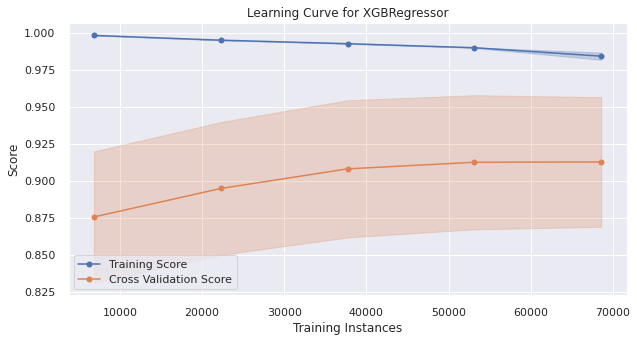

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


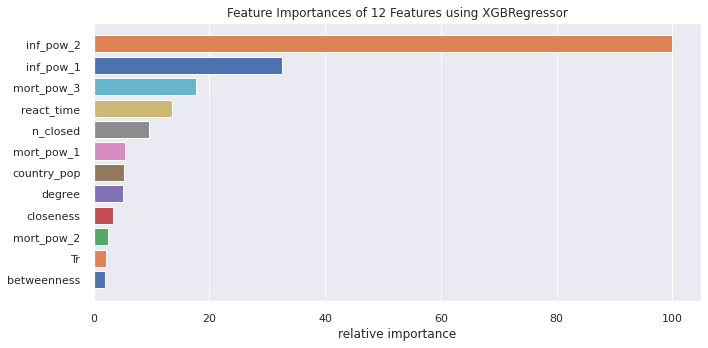

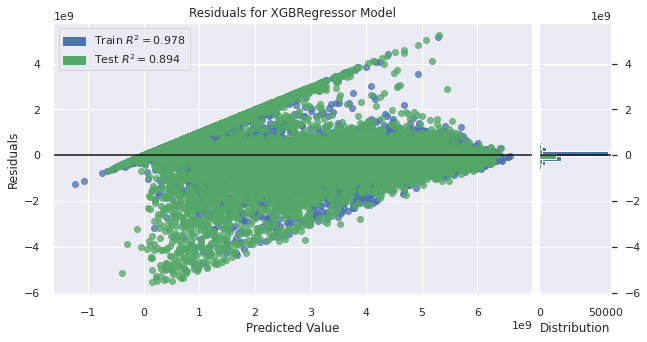

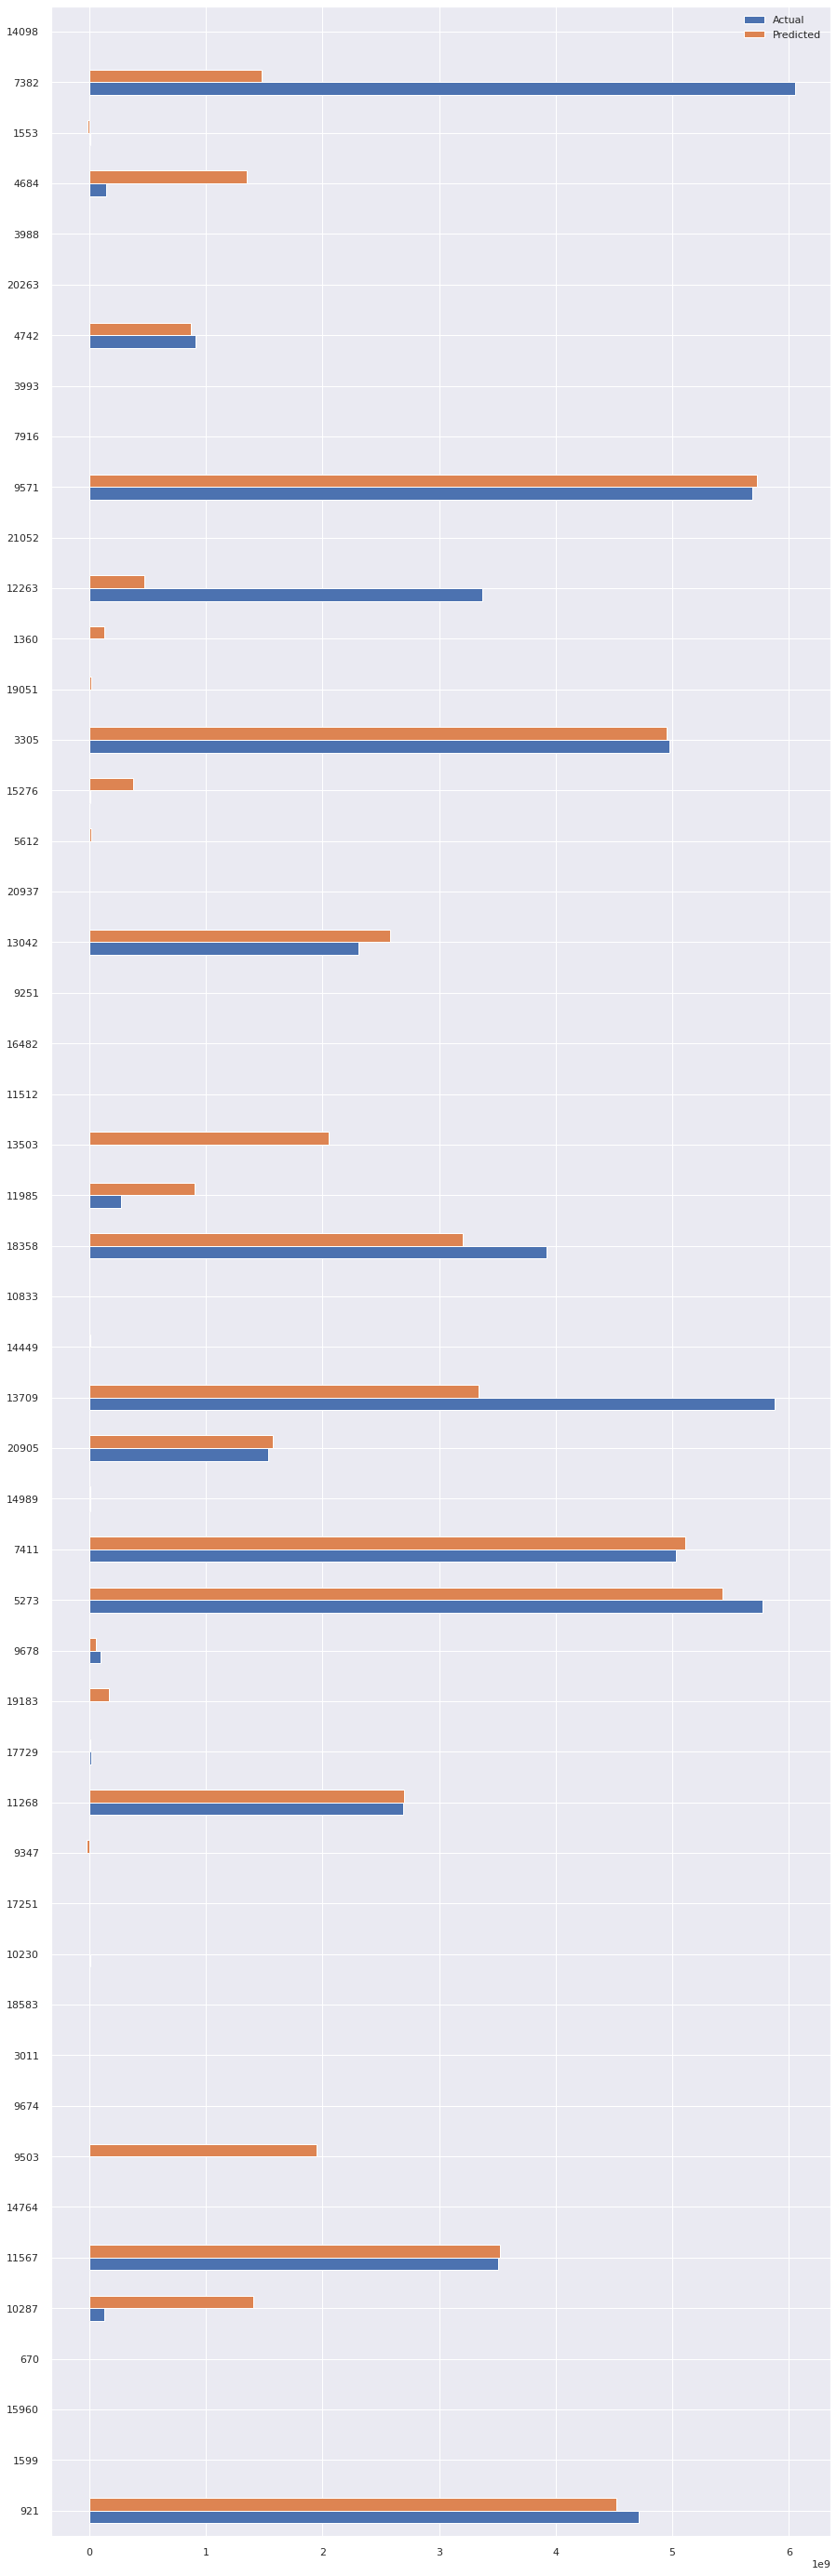

In [1]:
# =============================================================================
#
# =============================================================================


# allows to import own functions
import sys
import os
import re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv, make_train_val_test,\
    plot_predictions
from src.features.add_features import features_graph, features_pop
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from scipy.stats import randint
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.regressor import ResidualsPlot
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import time
from scipy.stats import uniform, expon, randint, loguniform



# Read data
df = pd.read_csv(
    f'{root_project}/data/processed/simulation_results_rev17_wide.csv')
# Load features
df = features_graph(df)
df = features_pop(df)

# keep track of the original dataset
df_model = df.copy()

# size_data = 10000 # enter  desired subset of data
# df_model = df_model.sample(size_data)

features = [
    'Tr',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_deceased',
    'betweenness',
    'degree',
    'closeness',
    'country_pop']


df_model = df_model[features]


samples = df_model.shape[0]
features = df_model.shape[1]
run_time = time.strftime("run_%d_%m_%Y-%H_%M_%S")
MODEL_NAME = 'xgboost_rev17'
# Path to save the model
PATH = f"{root_project}/models/{MODEL_NAME}-{samples}-samples-{features}-feat-{run_time}.pkl"

X_train_val, y_train_val, X_test, y_test = make_train_val_test(df_model,
                                                               out_mode=1)


param_dist = dict(
    n_estimators=randint(low=15, high=25),
    max_depth=randint(low=5, high=20),
    learning_rate=loguniform(0.001, 1),
    subsample=uniform(loc=0.8, scale=1-0.8),
    colsample_bytree=uniform(loc=0.8, scale=1-0.8),
    gamma=[0, 1, 5]
)

random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42),
                                   param_distributions=param_dist, verbose=1,
                                   n_iter=100, cv=3,
                                   random_state=42, n_jobs=-1)

# random_search.fit(X_train_val, y_train_val)
# joblib.dump(random_search, PATH)

# Load the model in path
random_search = joblib.load(f"{root_project}/models/xgboost_rev17-99785-samples-13-feat-run_31_08_2020-18_51_37.pkl")

results_searchcv(random_search, X_test, y_test)


fig, ax = plt.subplots(1, 1, figsize = (10,5))
visualizer = LearningCurve(random_search.best_estimator_, n_jobs=6)
visualizer.fit(X_train_val, y_train_val)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

fig, ax = plt.subplots(1, 1, figsize = (10,5))
viz = FeatureImportances(random_search.best_estimator_)
viz.fit(X_train_val, y_train_val)
viz.show()


fig, ax = plt.subplots(1, 1, figsize = (10,5))
viz = ResidualsPlot(random_search.best_estimator_)
viz.fit(X_train_val, y_train_val)
viz.score(X_test, y_test)
viz.show()

plot_predictions(random_search, X_test, y_test, samples=50)

In [2]:
X_err = X_test.copy()

X_err['predicted'] = random_search.predict(X_test)

X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err_sorted = X_err.sort_values(by='abs_error', ascending=False).iloc[:100]
error_idx = X_err_sorted.index

In [3]:
number_subplots = len(df.describe().columns)
number_subplots

18

In [4]:
number_subplots = len(df.describe().columns)
width = 4
high = number_subplots/4
if number_subplots%4 != 0:
    high = int(high+1)
width, high

(4, 5)

/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.

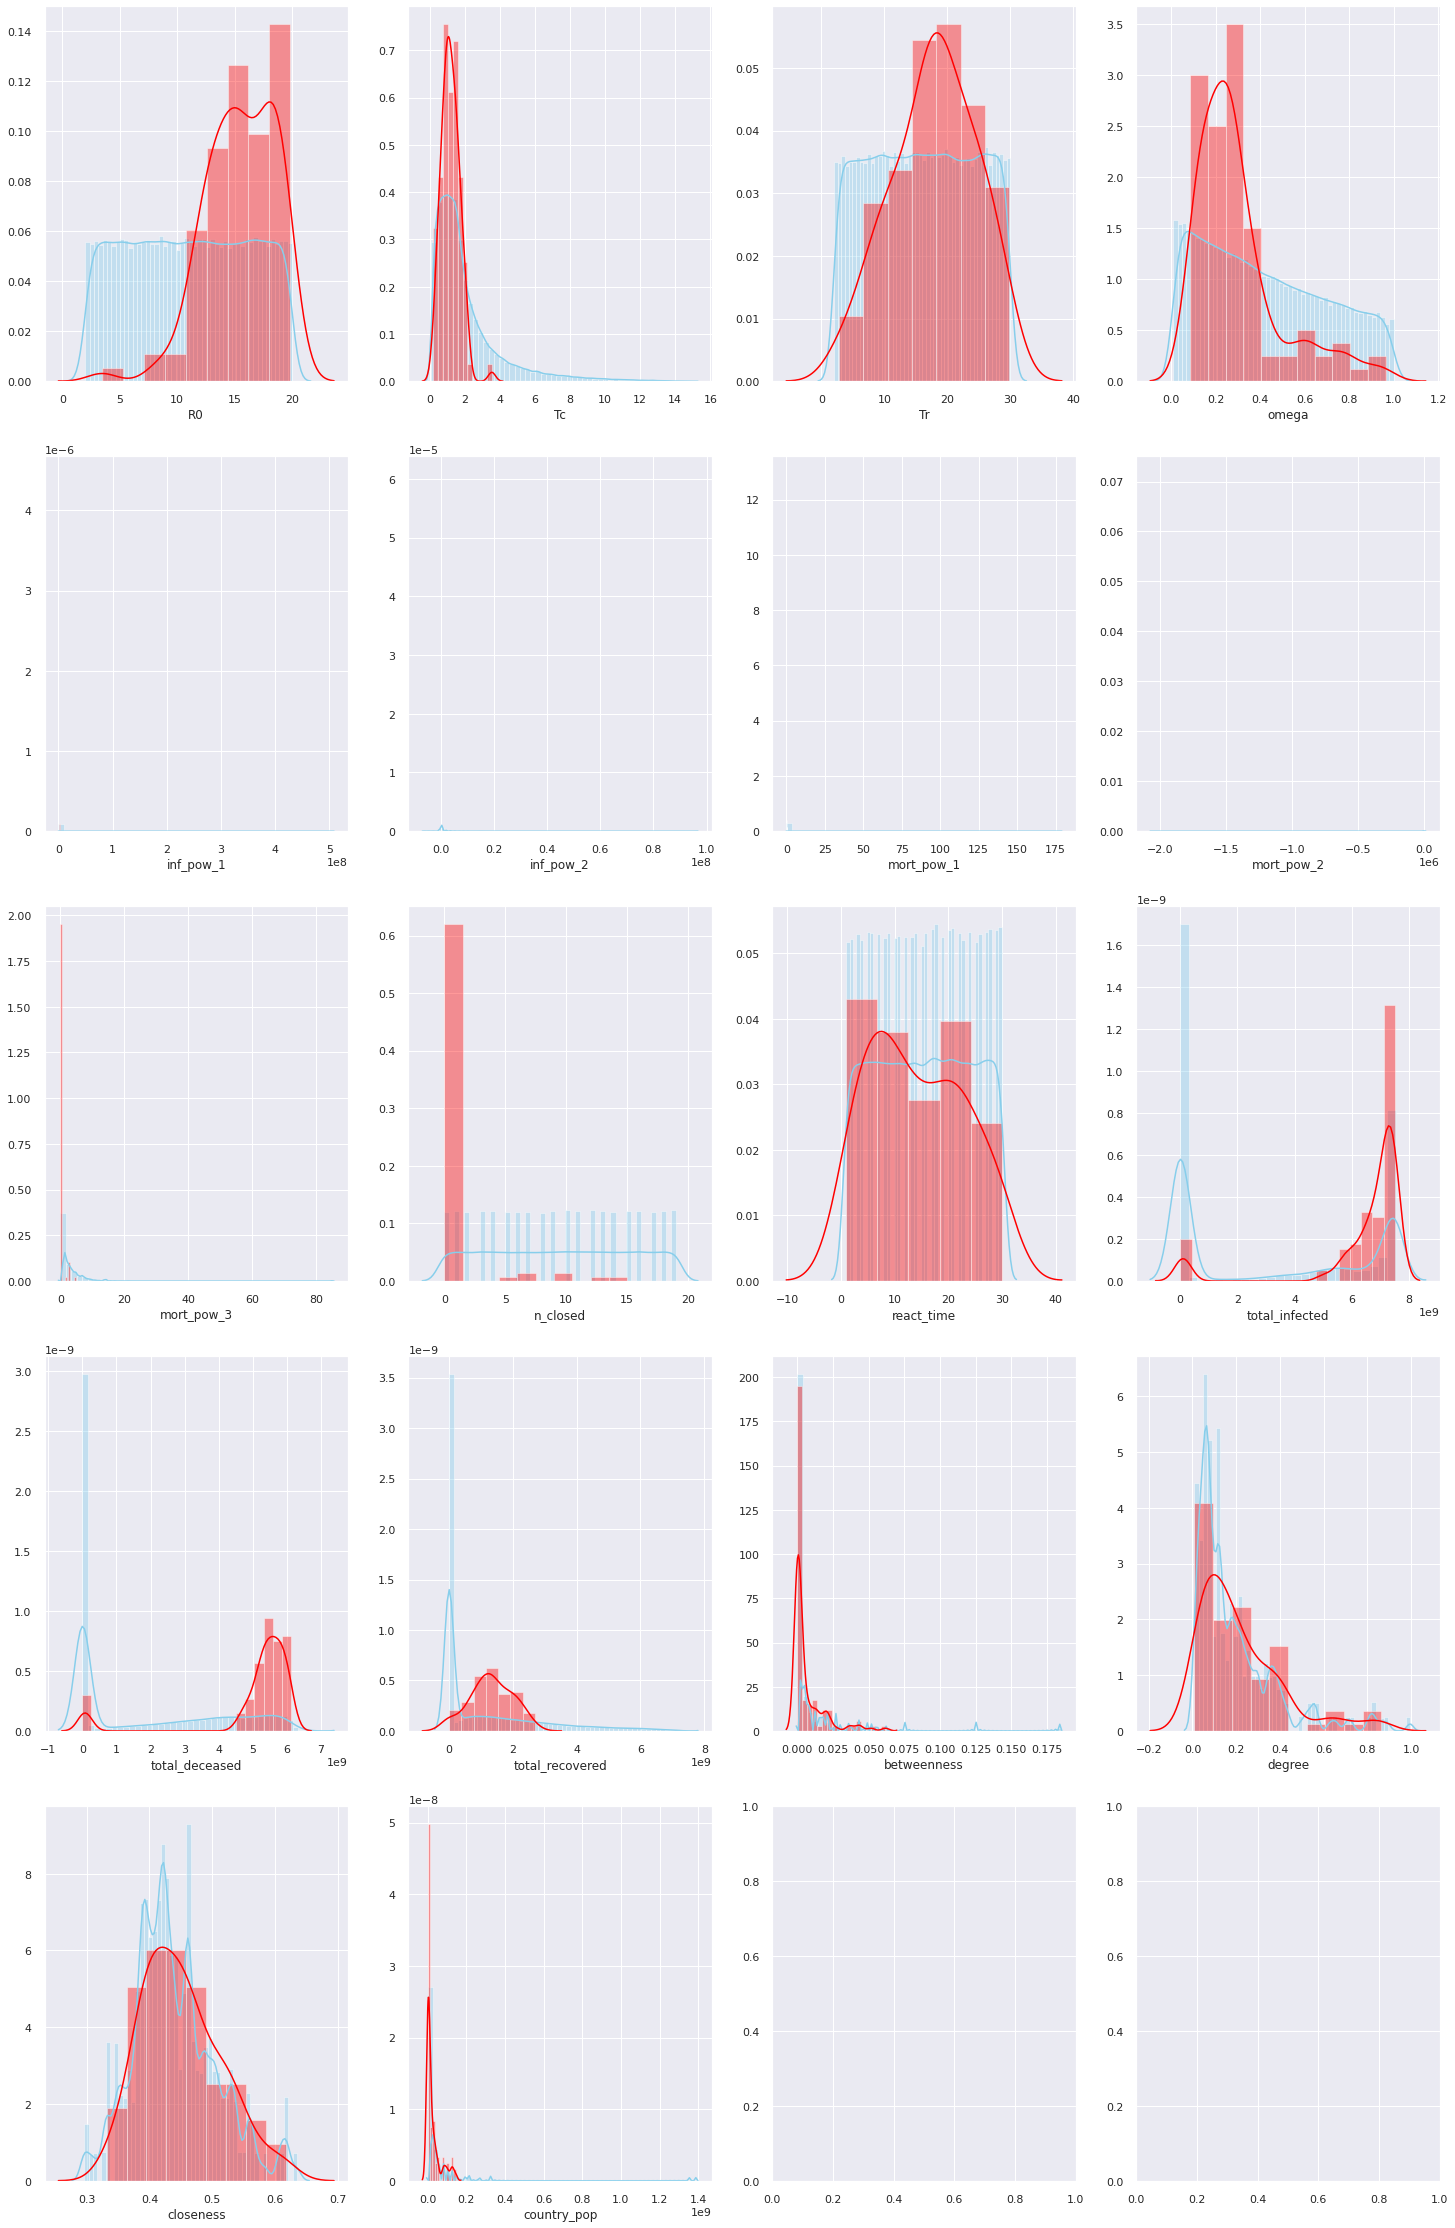

In [5]:
fig, ax = plt.subplots(high, width, figsize=(25,40))

ax = ax.ravel()

for i, feature in enumerate(df.describe().columns):
    sns.distplot(df[feature], hist=True, color='skyblue',
           label='Original', ax=ax[i])
    sns.distplot(df.loc[error_idx, feature], hist=True, color='red',
           label='Errors', ax=ax[i])

In [6]:
from src.utils.help_func import errors_distribution


In [7]:
df

,i_country,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,n_closed,react_time,total_infected,total_deceased,total_recovered,betweenness,degree,closeness,country_pop
0,NIC,15.127089,1.432646,21.671765,0.810188,0.000000,0.000000,0.000000,0.000000,0.000000,0,13,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.045045,0.386760,6465513.0
1,MAC,11.712490,1.513652,17.728633,0.300084,23.071429,49.500000,0.445820,0.727273,3.891892,18,30,3.959359e+09,3.332951e+09,6.264778e+08,0.000000,0.081081,0.378194,631636.0
2,ZWE,11.196699,0.973025,10.894668,0.201303,1162.785714,2241.777778,0.195651,0.157861,1.262386,18,23,7.193707e+09,4.940972e+09,2.252924e+09,0.000288,0.072072,0.405109,14439018.0
3,GNQ,2.841725,8.012827,22.770250,0.930842,0.000000,0.000000,0.000000,0.000000,0.000000,5,7,1.000000e+00,0.000000e+00,0.000000e+00,0.000072,0.063063,0.391534,1308974.0
4,SAU,15.554773,1.814752,28.228049,0.468460,1.214286,1.000000,0.823529,7.000000,7.000000,5,24,5.458733e+06,5.074933e+06,3.835420e+05,0.009627,0.387387,0.526066,33699947.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107104,MRT,6.012899,2.745283,16.507106,0.996971,0.000000,0.000000,0.000000,0.000000,0.000000,15,22,1.000000e+00,0.000000e+00,0.000000e+00,0.000046,0.063063,0.402904,4403319.0
107105,AFG,12.195345,0.917306,11.186860,0.836471,4.214286,12.000000,0.779661,3.833333,7.666667,18,13,1.074755e+07,9.709895e+06,1.037583e+06,0.000023,0.067568,0.397849,37172386.0
107106,CPV,14.709345,0.980862,14.427838,0.243552,894.714286,1820.250000,0.240300,0.206702,2.067308,7,25,7.310937e+09,5.691455e+09,1.619681e+09,0.004232,0.126126,0.462500,543767.0
107107,RUS,18.272992,0.780425,14.260703,0.216171,11550.785714,16688.133333,0.168690,0.108976,1.545377,9,29,7.491545e+09,5.656808e+09,1.834985e+09,0.019294,0.630631,0.556391,144478050.0


/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/disks/hdd2T/Drive/TFM-master/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.

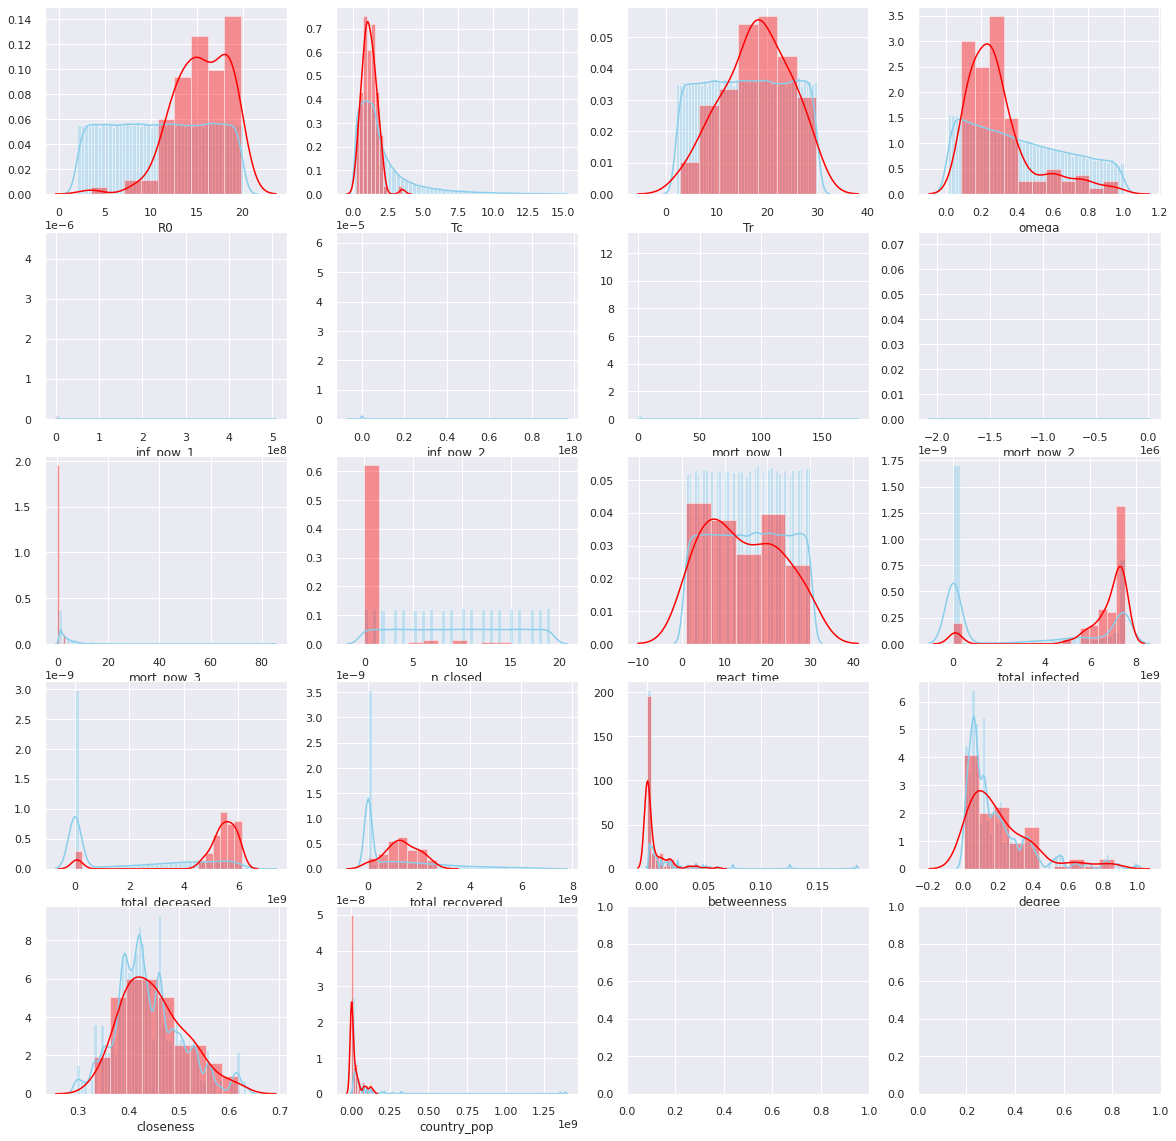

In [13]:
errors_distribution(random_search, X_test, y_test, df, figsize=(20,20))